adjust the NumPy version accordingly before running the program, and restart environment afterward

In [ ]:
# pip install numpy==1.26.4

## data pre-processing

In [ ]:
# import libraries
import pandas as pd
import json
import re
import numpy as np

In [ ]:
def extract_claims_from_patent(patent):
    claims_sections = patent.get("claims", [])
    extracted_claims = []

    for lang_section in claims_sections:
        if isinstance(lang_section, dict) and lang_section.get("lang") == "en" and "claims" in lang_section: # only english content
            for claim_entry in lang_section["claims"]:
                if isinstance(claim_entry, dict):
                    claim_text_list = claim_entry.get("claim_text")
                    if isinstance(claim_text_list, list):
                        for text in claim_text_list:
                            if isinstance(text, str):
                                extracted_claims.append(text)
            break

    return extracted_claims

In [ ]:
processed_data_list = []

# read .jsonl file(data0603.jsonl)
with open('data0603.jsonl', 'r', encoding='utf-8-sig') as f:
    for line in f:
        try:
            patent = json.loads(line)
        except json.JSONDecodeError:
            continue
        # get patent id
        patent_id = patent.get('lens_id', '')
        biblio = patent.get('biblio', {})

        # get abstract
        abstract_text = ''
        abstract_list = patent.get('abstract', [])
        for abstract_item in abstract_list:
            if abstract_item.get('lang') == 'en': # only keep english abstract
                abstract_text = abstract_item.get('text', '')
                break

        # is abstract is empty -> skip (some patent do not have abstract)
        if abstract_text:
            processed_data_list.append({
                'patent_id': patent_id,
                'claim_number': 0, # set abstract claim number is 0
                'processed_text': abstract_text,
                'original_claim_text': abstract_text
            })

        # extract claims texts
        claims_text_list = extract_claims_from_patent(patent) # The complete claims data, the format of the claim entries is inconsistent.
        if not claims_text_list:
            continue  # if claim text is empty, skip

        claims_map = {}
        for claim_text in claims_text_list:
            match = re.match(r'^\s*(\d+)\.', claim_text)
            if match:
                claim_number = int(match.group(1))
                claims_map[claim_number] = claim_text
            else:
                # claim number
                claim_number = max(claims_map.keys(), default=0) + 1
                claims_map[claim_number] = claim_text

        # handling the contextual relationships between claims. example: claim 1 [SEP] claim 8
        for claim_number, claim_text in sorted(claims_map.items()):
            processed_text = claim_text
            dependency_match = re.search(r'claim\s+(\d+)', claim_text, re.IGNORECASE)
            if dependency_match:
                parent_claim_number = int(dependency_match.group(1))
                parent_text = claims_map.get(parent_claim_number)
                if parent_text:
                    processed_text = f"{parent_text} [SEP] {claim_text}"
            processed_data_list.append({
                'patent_id': patent_id,
                'claim_number': claim_number,
                'processed_text': processed_text,
                'original_claim_text': claim_text
            })

# output dataframe (df_processed)
df_processed = pd.DataFrame(processed_data_list)

print("Number of Abstract (claim_number == 0):")
print(len(df_processed[df_processed['claim_number'] == 0]))

print("\nNumber of Claims (claim_number > 0):")
print(len(df_processed[df_processed['claim_number'] > 0]))

print("\nAbstract example:")
print(df_processed[df_processed['claim_number'] == 0].head(3))

Number of Abstract (claim_number == 0):
25

Number of Claims (claim_number > 0):
550

Abstract example:
              patent_id  claim_number  \
0   174-238-555-383-763             0   
19  147-591-134-013-631             0   
40  018-180-943-260-68X             0   

                                       processed_text  \
0   A system for operating a vehicle based on a st...   
19  Surveillance systems and methods for collectin...   
40  Systems and methods are disclosed for using an...   

                                  original_claim_text  
0   A system for operating a vehicle based on a st...  
19  Surveillance systems and methods for collectin...  
40  Systems and methods are disclosed for using an...  


In [ ]:
# read human-annotated dataset (3 .csv file)
df_labels1 = pd.read_csv("/content/kt-patents-dataset.csv")
df_labels2 = pd.read_csv("/content/ad.csv")
s_df = pd.read_csv("self.csv")
df_labels2 = df_labels2.iloc[:38,:]
df_combined = pd.concat([df_labels1, df_labels2, s_df], ignore_index=True) # merge dataframe
df_labels = df_combined.copy()

In [ ]:
risk_columns = [col for col in df_labels.columns if col.startswith('Human right') or
                col.startswith('Transparency risk') or
                col.startswith('Unacceptable risk') or
                col.startswith('High risk')]
# just to check 33 risk columns

In [ ]:
get_id = r"https://(?:www\.)?lens\.org/(?:lens/patent/)?([A-Za-z0-9\-]+)" # get patent id

df_labels["patent_id"] = df_labels["URL (note that multiple snippets can have the same URL)"].apply(lambda x: re.search(get_id, str(x)).group(1) if re.search(get_id, str(x)) else None)
df_labels = df_labels.dropna(subset=["patent_id"]).reset_index(drop=True) # drop empty one

col_name = df_labels.columns[5:-1]
# y or yes : 1 otherwise 0
df_labels[col_name] = df_labels[col_name].applymap(
    lambda x: int(
        str(x).lower() in ['y', 'yes'] or str(x).strip() in ['1', '1.0']
    ) if pd.notna(x) else 0)

In [ ]:
# show the number of sample for each risk type
for col in risk_columns:
    print(f"\n{col} category summary：")
    print(df_labels[col].value_counts(dropna=False))


Unacceptable risk p1 (harmful AI-based manipulation and deception) category summary：
Unacceptable risk p1 (harmful AI-based manipulation and deception)
0    122
1      3
Name: count, dtype: int64

Unacceptable risk p2 (harmful AI-based exploitation of vulnerabilities) category summary：
Unacceptable risk p2 (harmful AI-based exploitation of vulnerabilities)
0    120
1      5
Name: count, dtype: int64

Unacceptable risk p3 (social scoring) category summary：
Unacceptable risk p3 (social scoring)
0    125
Name: count, dtype: int64

Unacceptable risk p4 (individual criminal offence risk assessment or prediction) category summary：
Unacceptable risk p4 (individual criminal offence risk assessment or prediction)
0    116
1      9
Name: count, dtype: int64

Unacceptable risk p5 (untargeted scraping of the internet or CCTV material to create or expand facial recognition databases) category summary：
Unacceptable risk p5 (untargeted scraping of the internet or CCTV material to create or expand fa

In [ ]:
# create risk columns and fill with 0 on df_processed
for col in risk_columns:
    df_processed[col] = 0

In [ ]:
# text normalization
def normalize_text(text):
    """Convert text to lowercase and replace all sequences of whitespace characters
    (including spaces, newlines, and tabs) with a single space"""
    if not isinstance(text, str):
        return ""
    text = text.lower() # Convert to lowercase
    # text = re.sub(r'\s+', ' ', text) # replace all consecutive whitespace with a single space
    text = re.sub(r'^\d+\.\s*', '', text) # remove leading number
    text = re.sub(r'[^\w\s]', '', text) # remove punctuation
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# remove leading number
def remove_leading_number(text):
    if not isinstance(text, str):
        return ""
    return re.sub(r'^\d+\.\s*', '', text)

# create two temporary columns for comparison
# normalized original text
df_processed['normalized_text'] = df_processed['original_claim_text'].apply(normalize_text)
df_processed['no_num_normalized_text'] = df_processed['normalized_text'].apply(remove_leading_number)

In [ ]:
df_processed

In [ ]:
# create a new column to store successfully matched snippets; default is empty
df_processed['matched_snippet'] = pd.NA


# create columns for comparison
df_processed['normalized_text'] = df_processed['original_claim_text'].apply(normalize_text)
df_processed['no_num_normalized_text'] = df_processed['normalized_text'].apply(remove_leading_number)

# iterate through the annotation file
unmatched_snippets = []
for index, label_row in df_labels.iterrows():
    patent_id = label_row['patent_id'] # use patent id for match
    snippet_original = label_row['Text snippet from Summary or Claims (as short as possible, can be less than a paragraph)']
    snippet_normalized = normalize_text(snippet_original)

    if not snippet_normalized: continue

    mask = (df_processed['patent_id'] == patent_id) & \
           (df_processed['no_num_normalized_text'].str.contains(snippet_normalized, regex=False, na=False))

    if mask.sum() == 0:
        mask = (df_processed['patent_id'] == patent_id) & \
               (df_processed['normalized_text'].str.contains(snippet_normalized, regex=False, na=False))

    if mask.sum() > 0:
        # renew risk columns
        for risk_col in risk_columns:
            if label_row.get(risk_col) == 1:
                df_processed.loc[mask, risk_col] = 1

        # still keep important snippet and save
        df_processed.loc[mask, 'matched_snippet'] = snippet_original

    else:
        unmatched_snippets.append(label_row)

print(f"Match complete {len(unmatched_snippets)} data can't find from original text")
if unmatched_snippets:
    print("Unmatch snippet:")
    df_unmatched = pd.DataFrame(unmatched_snippets)
    for snippet_text in df_unmatched['Text snippet from Summary or Claims (as short as possible, can be less than a paragraph)'].head(5): # show head 5 text
        print(f"- {snippet_text}...")

# drop temporary columns
df_processed = df_processed.drop(columns=['normalized_text', 'no_num_normalized_text'])

df_final = df_processed


Match complete 79 data can't find from original text
Unmatch snippet:
- In certain embodiments, the one or more ML models may include a generic ML model which may have been trained using offline training data associated with various differentiating physical and behavioral characteristics of humans, e.g., facial expressions (e.g., calm, fear, anger, regret, frustration, or excitement), tone (e.g., angry, threatening, soft, anxious, or loud), emotions (e.g., crying, sobbing, screaming, pleading, or apologetic), body language or movements (e.g., hands in the air, pointing a weapon, holding an object), among others. The application policy engine may execute the generic ML model to infer biometric characteristics of the subject given the real time input data stream. For example, the generic ML model may be used to infer anger, a threatening tone, or a weapon in subject's possession using the real time input data stream. The generic ML models can be different for different genders, races, et

In [ ]:
df_unmatched_formatted = pd.DataFrame({
    'patent_id': df_unmatched['patent_id'],
    'claim_number': -1, # add the number for the umatched snippet
    'processed_text': df_unmatched['Text snippet from Summary or Claims (as short as possible, can be less than a paragraph)'],
    'original_claim_text': '',
})

# add it ti risk columns
for col in risk_columns:
    df_unmatched_formatted[col] = df_unmatched[col]
# df_final contains all data(33 risk xlasses)
df_final = pd.concat([df_final, df_unmatched_formatted], ignore_index=True)

In [ ]:
columns_to_drop = ['claim_number', 'patent_id', 'original_claim_text'] # remove useless columns
df_final = df_final.drop(columns=columns_to_drop)

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 654 entries, 0 to 653
Data columns (total 35 columns):
 #   Column                                                                                                                                                                       Non-Null Count  Dtype 
---  ------                                                                                                                                                                       --------------  ----- 
 0   processed_text                                                                                                                                                               654 non-null    object
 1   Unacceptable risk p1 (harmful AI-based manipulation and deception)                                                                                                           654 non-null    int64 
 2   Unacceptable risk p2 (harmful AI-based exploitation of vulnerabilities)               

## Semantic Similarity (Baseline)

In [ ]:
# import libraries
from sklearn.model_selection import train_test_split

In [ ]:
# split dataset 80 train /20 test
dev_df, test_df = train_test_split(
    df_final,
    test_size=0.2,
    random_state=42
)

print("Dataset split completed!")
print(f"dev_df size: {dev_df.shape}")
print(f"test_df size: {test_df.shape}")

Dataset split completed!
dev_df size: (523, 35)
test_df size: (131, 35)


In [ ]:
# the naming of the original columns carries risk-related semantic implications
risk_definitions_map = {f"risk_{i+1}": definition for i, definition in enumerate(risk_columns)}

print(f"{len(risk_columns)} risk definitions have been successfully prepared")
print("Risk definition examples:")
print(risk_columns[0])

33 risk definitions have been successfully prepared
Risk definition examples:
Unacceptable risk p1 (harmful AI-based manipulation and deception)


In [ ]:
# import libraries
from sentence_transformers import SentenceTransformer
from sentence_transformers import util
import torch

[Sentence Transformer](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2)

In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')

# vector embedding (text)
claim_embeddings = model.encode(dev_df['processed_text'].tolist(), convert_to_tensor=True, show_progress_bar=True)

# vector embedding (risk)
risk_embeddings = model.encode(risk_columns, convert_to_tensor=True)
print("Vector generation completed!")

In [ ]:
# compute the cosine similarity between patent text vectors and risk definition vectors
# [number of patents × number of risks] similarity matrix
cosine_scores = util.cos_sim(claim_embeddings, risk_embeddings)

# set a threshold for determining potential risk; if the similarity score exceeds this value,
# the claim is considered potentially associated with a risk
# similarity_threshold = 0.5 # defult = 0.5

In [ ]:
# import libraries
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt

In [ ]:
true_labels = dev_df[risk_columns].values # .values transfor it into numpy metrix

print("True label matrix, Shape:", true_labels.shape)
print("Prediction score matrix, Shape:", cosine_scores.shape)

True label matrix, Shape: (523, 33)
Prediction score matrix, Shape: torch.Size([523, 33])



Best F1 score: 0.0549
Best Threshold: 0.37


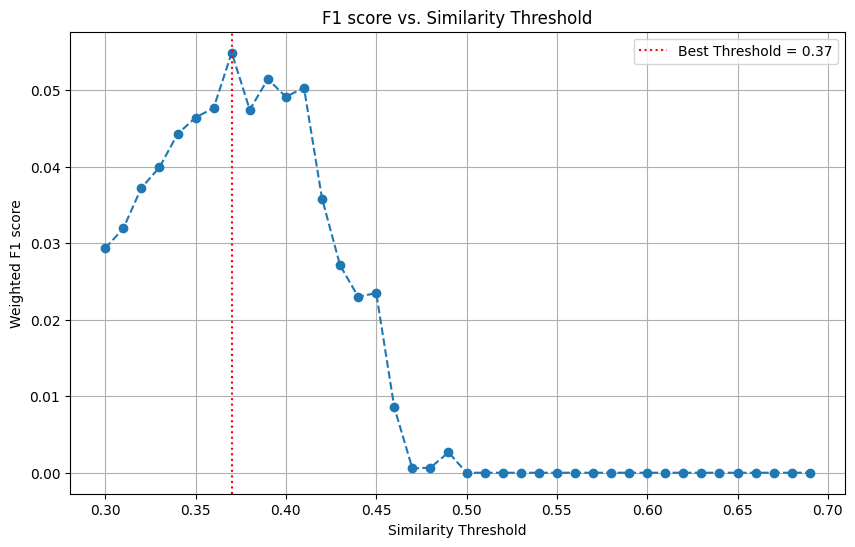

In [ ]:
# generate a series of threshold values to test
thresholds = np.arange(0.3, 0.7, 0.01)

# store the F1 score corresponding to each threshold
f1_scores = []

# convert to numPy array
cosine_scores_np = cosine_scores.cpu().numpy()

for threshold in thresholds:
    # binary predictions (0 or 1) based on the current threshold
    predicted_labels = (cosine_scores_np >= threshold).astype(int)

    # compute the F1 score
    # average='weighted' for class imbalance
    # zero_division=0 for prevent errors
    f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=0)

    f1_scores.append(f1)

# identify the threshold that yields the highest F1 score
best_f1_index = np.argmax(f1_scores)
best_threshold = thresholds[best_f1_index]
best_f1_score = f1_scores[best_f1_index]

print(f"\nBest F1 score: {best_f1_score:.4f}")
print(f"Best Threshold: {best_threshold:.2f}")

# visualization
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, marker='o', linestyle='--')
plt.axvline(x=best_threshold, color='r', linestyle=':', label=f'Best Threshold = {best_threshold:.2f}')
plt.title('F1 score vs. Similarity Threshold')
plt.xlabel('Similarity Threshold')
plt.ylabel('Weighted F1 score')
plt.grid(True)
plt.legend()
plt.show()

# output:
# Best F1 score: 0.0549
# Best Threshold: 0.37

In [ ]:
# Generate vector for the text in test_df
print("\n--- Starting final evaluation on the test set ---")
print(f"Generating vectors for {len(test_df)} test samples...")
test_claim_embeddings = model.encode(test_df['processed_text'].tolist(), convert_to_tensor=True, show_progress_bar=True)

# compute similarity scores
test_cosine_scores = util.cos_sim(test_claim_embeddings, risk_embeddings)
test_cosine_scores_np = test_cosine_scores.cpu().numpy()

# prepare true labels for the test set
test_true_labels = test_df[risk_columns].values

# generate final predictions using the optimal threshold we identified
final_predicted_labels = (test_cosine_scores_np >= best_threshold).astype(int)

# output report
print(f"\nFinal evaluation report on the test set using the optimal threshold ({best_threshold:.2f}):")

# zero_division=0 prevents errors
report = classification_report(test_true_labels, final_predicted_labels, target_names=risk_columns, zero_division=0)
print(report)

If the result image does not display correctly
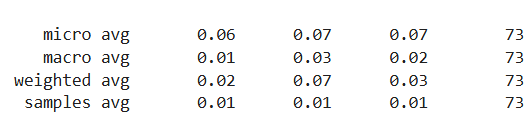

## Semantic Similarity (Enhanced)

In [ ]:
# Key: risk column name
# Value: risk describe(detailed)
enriched_risk_definitions = {
    "Unacceptable risk p1 (harmful AI-based manipulation and deception)":
        "AI systems that use deceptive techniques to manipulate human behaviour or decision-making are banned. These systems undermine autonomy and democratic integrity.",

    "Unacceptable risk p2 (harmful AI-based exploitation of vulnerabilities)":
        "AI targeting vulnerable groups like children or disabled individuals by exploiting their weaknesses is prohibited. This ensures protection for those unable to resist manipulation.",

    "Unacceptable risk p3 (social scoring)":
        "AI that scores people based on behaviour, social status, or personal traits is disallowed. Such systems threaten equality and civil liberties.",

    "Unacceptable risk p4 (individual criminal offence risk assessment or prediction)":
        "Predictive AI systems assessing criminal risk are forbidden due to potential profiling and discrimination. They undermine the right to a fair trial.",

    "Unacceptable risk p5 (untargeted scraping of the internet or CCTV material to create or expand facial recognition databases)":
        "Mass scraping of online or CCTV data to build facial recognition databases is banned. It prevents invasive surveillance and protects privacy.",

    "Unacceptable risk p6 (emotion recognition in workplaces and education institutions)":
        "Emotion recognition tools in schools and workplaces are not allowed. They intrude on mental privacy and can cause biased treatment.",

    "Unacceptable risk p7 (biometric categorisation to deduce certain protected characteristics)":
        "AI that deduces race, religion, or orientation from biometric data is banned. This prevents discriminatory profiling and protects sensitive attributes.",

    "Unacceptable risk p8 (real-time remote biometric identification for law enforcement purposes in publicly accessible spaces)":
        "Real-time biometric identification by law enforcement in public areas is prohibited. It poses serious risks to privacy and freedom of movement.",

    "High risk u1 (AI safety components in critical infrastructures (e.g. transport), the failure of which could put the life and health of citizens at risk)":
        "AI in critical sectors like transport is high-risk due to potential safety failures. Robust testing and oversight are required.",

    "High risk u2 (AI solutions used in education institutions, that may determine the access to education and course of someone’s professional life (e.g. scoring of exams))":
        "AI used for educational outcomes, such as exam scoring, is high-risk. It must ensure fairness and accountability.",

    "High risk u3 (AI-based safety components of products (e.g. AI application in robot-assisted surgery))":
        "AI embedded in safety-critical products like surgical robots requires strict certification. Failures could directly harm users.",

    "High risk u4 (AI tools for employment, management of workers and access to self-employment (e.g. CV-sorting software for recruitment))":
        "AI in hiring or workplace management is high-risk. Systems must avoid bias and be transparent in decisions.",

    "High risk u5 (Certain AI use-cases utilised to give access to essential private and public services (e.g. credit scoring denying citizens opportunity to obtain a loan))":
        "AI affecting access to services like loans is high-risk. They must be explainable and offer means for redress.",

    "High risk u6 (AI systems used for remote biometric identification, emotion recognition and biometric categorisation (e.g AI system to retroactively identify a shoplifter))":
        "Non-real-time biometric systems are high-risk due to privacy and discrimination concerns. Proper safeguards are necessary.",

    "High risk u7 (AI use-cases in law enforcement that may interfere with people’s fundamental rights (e.g. evaluation of the reliability of evidence))":
        "Law enforcement AI that affects rights like due process is high-risk. Oversight and fairness are critical.",

    "High risk u8 (AI use-cases in migration, asylum and border control management (e.g. automated examination of visa applications))":
        "AI used in immigration or border decisions is high-risk. Systems must be transparent and protect individual rights.",

    "High risk u9 (AI solutions used in the administration of justice and democratic processes (e.g. AI solutions to prepare court rulings))":
        "AI in courts or democratic processes must be auditable and fair. It’s high-risk due to potential legal impacts.",

    "High risk health (risk to health)":
        "AI with medical applications like diagnosis or treatment must meet strict safety standards. These systems are high-risk.",

    "High risk safety (risk to safety)":
        "AI whose failure may endanger physical safety is high-risk. Safety-by-design is essential.",

    "High risk fundamental rights (risk to fundamental rights)":
        "AI that may infringe on rights like privacy or equality is high-risk. Impact assessments and human oversight are mandatory.",

    "Transparency risk (risks associated with a need for transparency around the use of AI, humans are informed when necessary to preserve trust)":
        "AI that interacts with humans must disclose its non-human nature. Transparency helps preserve user trust and informed consent.",

    "Human right to life":
        "AI must not endanger human life. Protection against lethal or negligent uses is fundamental.",

    "Human right to freedom from torture (and inhuman or degrading treatment or punishment)":
        "AI must never facilitate torture or degrading treatment. This is a non-derogable right under international law.",

    "Human right to freedom from slavery and forced labour":
        "AI systems must not support or enable forced labour. Human autonomy and dignity must be preserved.",

    "Human right to liberty and security (lawful arrest or detention, informed why arrested in language they understand)":
        "AI decisions related to arrest or detention must be lawful, justified, and clearly communicated in understandable language.",

    "Human right to a fair trial (assumed innocent)":
        "AI used in legal settings must uphold the presumption of innocence and due process. Individuals must be able to contest AI decisions.",

    "Human right to respect for private and family life":
        "AI must not intrude into personal or family life without legal basis. Privacy is a core human right.",

    "Human right to freedom of thought, conscience and religion":
        "AI must not manipulate or restrict beliefs. Freedom of thought must be safeguarded.",

    "Human right to freedom of expression":
        "AI must not suppress lawful speech. Automated moderation must be transparent and proportionate.",

    "Human right to freedom of assembly and association (protest)":
        "AI cannot be used to suppress peaceful protests or track participants. This right ensures collective political expression.",

    "Human right to marry":
        "AI must not arbitrarily restrict marriage eligibility. Legal processes must remain human-supervised.",

    "Human right to an effective remedy (right to legal remedy by person whose rights have been violated)":
        "When AI causes harm, affected individuals must have access to legal remedy. This includes appeals and compensation.",

    "Human right to freedom of discrimination":
        "AI must avoid unjust bias and ensure equal treatment. Discriminatory impacts must be proactively mitigated."
}

print(f"Successfully created {len(enriched_risk_definitions)} enriched risk definitions")

Successfully created 33 enriched risk definitions


[sentence-transformers all-mpnet-base-v2 ](https://huggingface.co/sentence-transformers/all-mpnet-base-v2)

In [ ]:
# risk definitions
risk_definitions_list_original_names = risk_columns

# risk_definitions_list_enriched
risk_definitions_list_enriched = list(enriched_risk_definitions.values())


# load model and generate vector
from sentence_transformers import SentenceTransformer

# model = SentenceTransformer('all-MiniLM-L6-v2') # old
model = SentenceTransformer('all-mpnet-base-v2')

# # Generate vector for the detailed risk definitions
risk_embeddings = model.encode(risk_definitions_list_enriched, convert_to_tensor=True, show_progress_bar=True)

# Generate vector for training text
claim_embeddings = model.encode(dev_df['processed_text'].tolist(), convert_to_tensor=True, show_progress_bar=True)


# compute cosine similarity scores
cosine_scores = util.cos_sim(claim_embeddings, risk_embeddings)
similarity_threshold = 0.5


#  preparing true labels, use the original column
true_labels = dev_df[risk_columns].values
cosine_scores = util.cos_sim(claim_embeddings, risk_embeddings)

thresholds = np.arange(0.3, 0.7, 0.01)
f1_scores = []
cosine_scores_np = cosine_scores.cpu().numpy()

for threshold in thresholds:
    predicted_labels = (cosine_scores_np >= threshold).astype(int)
    f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=0)
    f1_scores.append(f1)

# identify the threshold that yields the highest F1 score
best_f1_index = np.argmax(f1_scores)
best_threshold = thresholds[best_f1_index]
best_f1_score = f1_scores[best_f1_index]

print(f"\nBest F1 score: {best_f1_score:.4f}")
print(f"Best Threshold: {best_threshold:.2f}")

# visualization
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, marker='o', linestyle='--')
plt.axvline(x=best_threshold, color='r', linestyle=':', label=f'Best Threshold = {best_threshold:.2f}')
plt.title('F1 score vs. Similarity Threshold')
plt.xlabel('Similarity Threshold')
plt.ylabel('Weighted F1 score')
plt.grid(True)
plt.legend()
plt.show()

# generate vector for the text in test_df
print("\n--- Starting final evaluation on the test set ---")
print(f"Generating vectors for {len(test_df)} test samples...")
test_claim_embeddings = model.encode(test_df['processed_text'].tolist(), convert_to_tensor=True, show_progress_bar=True)

# compute similarity scores
test_cosine_scores = util.cos_sim(test_claim_embeddings, risk_embeddings)
test_cosine_scores_np = test_cosine_scores.cpu().numpy()

# preparing true labels
test_true_labels = test_df[risk_definitions_list_original_names].values

# generate final predictions using the optimal threshold
final_predicted_labels = (test_cosine_scores_np >= best_threshold).astype(int)

# output a detailed evaluation report
print(f"\nFinal evaluation report on the test set using the optimal threshold ({best_threshold:.2f}):")
# zero_division=0 prevents errors
report = classification_report(test_true_labels, final_predicted_labels, target_names=risk_definitions_list_original_names, zero_division=0)
print(report)

# output
# Best F1 score: 0.0706
# Best Threshold: 0.38

If the result image does not display correctly
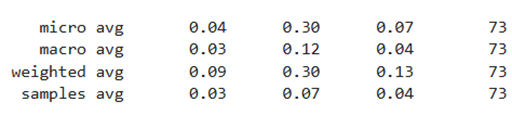

## Supervised Fine-Tuning (33 Sparse Categories) - Legal-BERT

In [ ]:
# import libraries
from sklearn.metrics import f1_score, classification_report, precision_recall_curve
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EvalPrediction

In [ ]:
columns_to_keep = ['processed_text'] + risk_columns
df_model_data = df_final[columns_to_keep].copy()

[nlpaueb/legal-bert-base-uncased](https://huggingface.co/nlpaueb/legal-bert-base-uncased)

In [ ]:
# data split
print("\nDataset split...")
model_checkpoint = "nlpaueb/legal-bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

train_df, val_df = train_test_split(df_model_data, test_size=0.2, random_state=42)
print(f"Training set size: {len(train_df)}, Validation set size: {len(val_df)}")


# label and data formatting
# print("\nFormatting data and Tokenization...")
# create the 'labels' column
train_df['labels'] = train_df[risk_columns].values.tolist()
val_df['labels'] = val_df[risk_columns].values.tolist()

# Remove the original risk columns
# risk columns define on data pre-processing section
train_df_for_dataset = train_df.drop(columns=risk_columns)
val_df_for_dataset = val_df.drop(columns=risk_columns)

train_dataset = Dataset.from_pandas(train_df_for_dataset)
val_dataset = Dataset.from_pandas(val_df_for_dataset)

# tokenization
def tokenize_function(examples):
    return tokenizer(examples["processed_text"], padding="max_length", truncation=True, max_length=512)
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)

# remove column
columns_to_remove = [col for col in tokenized_train_dataset.column_names if col not in ['labels', 'input_ids', 'attention_mask', 'token_type_ids']]
tokenized_train_dataset = tokenized_train_dataset.remove_columns(columns_to_remove)
tokenized_val_dataset = tokenized_val_dataset.remove_columns(columns_to_remove)
tokenized_train_dataset.set_format("torch")
tokenized_val_dataset.set_format("torch")


# data imbalance: compute class weights
print("\nCalculating classification weights")
train_labels = np.array(train_df[risk_columns].values)
pos_counts = np.sum(train_labels, axis=0)
neg_counts = len(train_labels) - pos_counts
pos_weight = np.where(pos_counts > 0, neg_counts / pos_counts, 1.0)
pos_weight_tensor = torch.tensor(pos_weight, dtype=torch.float)
print("calculated positive sample weight(pos_weight) applied to the loss function")


# Load model and custom Trainer (using weighted loss)
print("\nLoading the Legal-BERT model and Trainer...")
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(risk_columns),
    problem_type="multi_label_classification"
)

class WeightedLossTrainer(Trainer):
    # **kwargs to accept any additional parameters
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # pass the weights into the loss function
        # to(model.device) weights and model are on the same device
        loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor.to(model.device))
        loss = loss_fct(logits, labels.float())
        return (loss, outputs) if return_outputs else loss

# set training parameters and evaluation metrics
training_args = TrainingArguments(
    output_dir="./legal-bert-results-sparse",
    report_to="none",
    num_train_epochs=5,
    per_device_train_batch_size=4,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=20,
    eval_strategy="epoch", # edit to eval_strategy(version problem)
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_weighted",
)

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    true_labels = p.label_ids
    y_pred = (torch.sigmoid(torch.from_numpy(preds)).numpy() >= 0.5).astype(int)
    f1 = f1_score(y_true=true_labels, y_pred=y_pred, average='weighted', zero_division=0)
    return {"f1_weighted": f1}


# Training
trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    compute_metrics=compute_metrics,
)

print("\n--- fine-tuning the Legal-BERT ---")
trainer.train()

# Reoprt
print("\n--- Detailed classification report ---")
preds_output = trainer.predict(tokenized_val_dataset)
y_pred_final = (torch.sigmoid(torch.from_numpy(preds_output.predictions)).numpy() >= 0.5).astype(int)
y_true_final = preds_output.label_ids
report = classification_report(y_true_final, y_pred_final, target_names=risk_columns, zero_division=0)
print(report)

If the result image does not display correctly
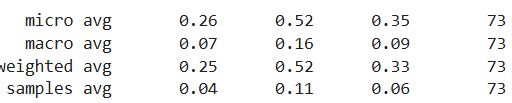

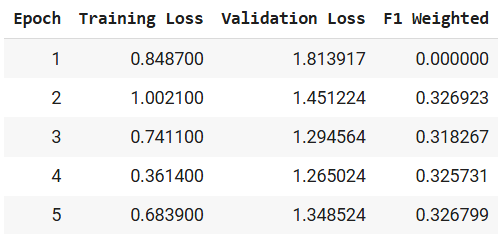

## Supervised Fine-Tuning (Manual Tuning) - Legal-BERT

In [ ]:
# new model, new import libraries
import pandas as pd
import numpy as np
import torch
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, precision_recall_curve
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EvalPrediction

In [ ]:
# Data preparation
print("--- combine (4 groups) ---")

# 33 risk columns into 4 categories
group_prefixes = [
    'Unacceptable risk',
    'High risk',
    'Transparency risk',
    'Human right'
]

# create new datframe
# keep processed_text and risk cols
df_model_data = df_final.copy()

# create by group_prefixes
grouped_risk_columns = []
for prefix in group_prefixes:
    group_name = f"Group: {prefix}"
    grouped_risk_columns.append(group_name)

    original_columns = [col for col in df_model_data.columns if col.startswith(prefix)]

    if original_columns:
        print(f"  - Big category '{group_name}'，Combine {len(original_columns)} sub-category")
        df_model_data[group_name] = df_model_data[original_columns].max(axis=1)
    else:
        df_model_data[group_name] = 0

# drop columns and create our final dataframe(4 groups): df_model_data
df_model_data = df_model_data[['processed_text'] + grouped_risk_columns].copy()
df_model_data.dropna(subset=['processed_text'], inplace=True)
df_model_data = df_model_data[df_model_data['processed_text'].str.strip() != ''].reset_index(drop=True)

print("\nAfter combine，each risk group Number Of Sample(support):")
print(df_model_data[grouped_risk_columns].sum())
print(f"Data prepare complete，number of data: {len(df_model_data)}")


# model training
# model setting and data splitting
model_checkpoint = "nlpaueb/legal-bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
# Split the pre-clustered df_model_data 80 train /20 test
train_df, val_df = train_test_split(df_model_data, test_size=0.2, random_state=42)

# formatting
train_df['labels'] = train_df[grouped_risk_columns].values.tolist()
val_df['labels'] = val_df[grouped_risk_columns].values.tolist()
# drop columns
train_df_for_dataset = train_df.drop(columns=grouped_risk_columns)
val_df_for_dataset = val_df.drop(columns=grouped_risk_columns)
train_dataset = Dataset.from_pandas(train_df_for_dataset)
val_dataset = Dataset.from_pandas(val_df_for_dataset)

def tokenize_function(examples):
    return tokenizer(examples["processed_text"], padding="max_length", truncation=True, max_length=512)
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)

columns_to_keep = ['labels', 'input_ids', 'attention_mask', 'token_type_ids']
columns_to_remove_train = [col for col in tokenized_train_dataset.column_names if col not in columns_to_keep]
tokenized_train_dataset = tokenized_train_dataset.remove_columns(columns_to_remove_train)
tokenized_val_dataset = tokenized_val_dataset.remove_columns(columns_to_remove_train)
tokenized_train_dataset.set_format("torch")
tokenized_val_dataset.set_format("torch")

# weight caculate
train_labels_np = np.array(train_df[grouped_risk_columns].values)
pos_counts = np.sum(train_labels_np, axis=0)
neg_counts = len(train_labels_np) - pos_counts
pos_weight = np.where(pos_counts > 0, neg_counts / pos_counts, 1.0)
pos_weight_tensor = torch.tensor(pos_weight, dtype=torch.float)
print("Finish- weight caculate")


# define and training
print("\n--- Define Model and Trainer ---")
# load model
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(grouped_risk_columns),
    problem_type="multi_label_classification"
)
# weight Trainer
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs): # no api: return_outputs=False
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor.to(model.device))
        loss = loss_fct(logits, labels.float())
        return (loss, outputs) if return_outputs else loss
# parameter
training_args = TrainingArguments(output_dir="./grouped-results", report_to="none", num_train_epochs=8, per_device_train_batch_size=4, learning_rate=2e-5, weight_decay=0.01, logging_steps=20, eval_strategy="epoch", save_strategy="epoch", load_best_model_at_end=True, metric_for_best_model="f1_weighted", greater_is_better=True)
def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    true_labels = p.label_ids
    y_pred = (torch.sigmoid(torch.from_numpy(preds)).numpy() >= 0.5).astype(int)
    f1 = f1_score(y_true=true_labels, y_pred=y_pred, average='weighted', zero_division=0)
    return {"f1_weighted": f1}

trainer = WeightedLossTrainer(model=model, args=training_args, train_dataset=tokenized_train_dataset, eval_dataset=tokenized_val_dataset, tokenizer=tokenizer, compute_metrics=compute_metrics)
# start
print("\n--- Start model training ---")
trainer.train()
print("--- Training complete ---")


# eval
print("\n--- Start optimized and compare ---")
# preds output
preds_output = trainer.predict(tokenized_val_dataset)
probabilities = torch.sigmoid(torch.from_numpy(preds_output.predictions)).numpy()
y_true = preds_output.label_ids

# compare with 0.5 thresholds
print("\n" + "="*60)
print("--- Report 1: use【(general) 0.5 thresholds】eval report ---")
print("="*60)
baseline_report = classification_report(y_true, (probabilities >= 0.5).astype(int), target_names=grouped_risk_columns, zero_division=0)
print(baseline_report)


# best thresholds (each)
best_thresholds_per_class = {}
for i, risk_name in enumerate(grouped_risk_columns):
    precision, recall, thresholds = precision_recall_curve(y_true[:, i], probabilities[:, i])
    f1s = (2 * precision * recall) / (precision + recall + 1e-7)
    f1s = f1s[:-1]
    thresholds = thresholds[:len(f1s)]
    if len(f1s) > 0:
        best_f1_idx = np.argmax(f1s)
        best_thresholds_per_class[risk_name] = thresholds[best_f1_idx]
    else:
        best_thresholds_per_class[risk_name] = 0.5

# final
print("\n" + "="*60)
print("--- Report 2: use【best threshold(each group)】eval report (final result) ---")
print("="*60)
y_pred_optimized = np.zeros_like(probabilities)
for i, risk_name in enumerate(grouped_risk_columns):
    threshold = best_thresholds_per_class[risk_name]
    y_pred_optimized[:, i] = (probabilities[:, i] >= threshold).astype(int)

optimized_report = classification_report(y_true, y_pred_optimized, target_names=grouped_risk_columns, zero_division=0)
print(optimized_report)

If the result image does not display correctly
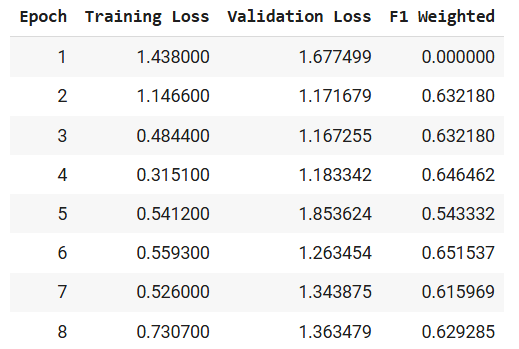
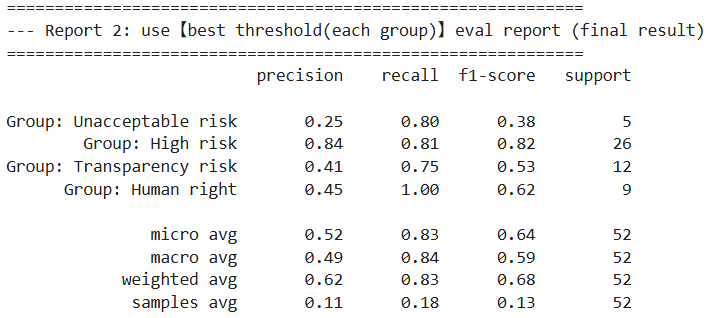

In [ ]:
# Just make sure basic libraries is imported
import json
import numpy as np

In [ ]:
# Save the model and the optimal threshold

# save model Tokenizer
model_save_directory = "./my_final_risk_classifier"
trainer.save_model(model_save_directory)
tokenizer.save_pretrained(model_save_directory)
print(f"Model and  Tokenizer success save to: {model_save_directory}")

# save the dictionary of optimal threshold values
thresholds_to_save = {key: float(value) for key, value in best_thresholds_per_class.items()}
thresholds_save_path = f"{model_save_directory}/best_thresholds.json"
with open(thresholds_save_path, 'w') as f:
    json.dump(thresholds_to_save, f, indent=4)
print(f"best thresholds save path: {thresholds_save_path}")

Model and  Tokenizer success save to: ./my_final_risk_classifier
best thresholds save path: ./my_final_risk_classifier/best_thresholds.json


In [ ]:
# Assume the code has never been executed before
# install and import required libraries
!pip install -q gradio

import gradio as gr
import torch
import json
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [ ]:
# Load model from file (save as pre-step)
print("--- Loading Model... ---")
model_path = "./my_final_risk_classifier"
thresholds_path = "./my_final_risk_classifier/best_thresholds.json"
try:
    loaded_model = AutoModelForSequenceClassification.from_pretrained(model_path)
    loaded_tokenizer = AutoTokenizer.from_pretrained(model_path)
    with open(thresholds_path, 'r') as f:
        loaded_thresholds = json.load(f)
    risk_categories = list(loaded_thresholds.keys())
    print("Model, Tokenizer and best thresholds loading successful!")
except FileNotFoundError:
    print("Error：can't find Model file")
    exit()

loaded_model.eval()

# # --- Step 2: Define the core prediction function (returns a dataFrame and a debug log)
def predict_risks(text_input):
    """
    text input and returns a result, a string containing detailed comparison logs for debugging.
    """
    if not text_input or not text_input.strip():
        # return an empty DataFrame and a prompt message
        return pd.DataFrame(columns=["Risk Group", "Predict probility", "Trigger (best thresholds)"]), "Enter Text to analysis"

    inputs = loaded_tokenizer(text_input, padding=True, truncation=True, max_length=512, return_tensors="pt")
    with torch.no_grad():
        outputs = loaded_model(**inputs)
    probabilities = torch.sigmoid(outputs.logits).numpy()[0]

    # Create a list to collect debug messages
    debug_log_lines = ["--- thresholds and probility compare log ---"]

    results = []
    for i, risk_name in enumerate(risk_categories):
        prob = probabilities[i]
        optimal_threshold = loaded_thresholds.get(risk_name, 0.5)

        # append debug messages to the list
        debug_log_lines.append(f"Risk: {risk_name}")
        debug_log_lines.append(f"  - Probility: {prob:.4f}")
        debug_log_lines.append(f"  - Threshold: {optimal_threshold:.4f}  <-- from json file")

        triggered = "🚨 YES" if prob >= optimal_threshold else "✅ NO"

        if triggered == "🚨 YES":
            debug_log_lines.append("  - Result: Risk warning!")

        debug_log_lines.append("-" * 20)

        results.append({
            "Risk Group": risk_name,
            "Predict probility": f"{prob:.4f}",
            "Trigger (best thresholds)": triggered
        })

    debug_log_lines.append("--- Complete ---")

    # combine all collected debug messages
    debug_log_string = "\n".join(debug_log_lines)

    results_df = pd.DataFrame(results)

    # return two outputs: the results df and the debug log string
    return results_df, debug_log_string

# Create ad start Gradio interactive interface
print("\n--- Create Gradio interactive interface... ---")

iface = gr.Interface(
    fn=predict_risks,
    inputs=gr.Textbox(
        lines=15,
        label="Enter Patent Text (Claims or Abstract)",
        placeholder="Paste Patent Text Here..."
    ),
    # convert the outputs parameter into a list to align with the function’s two return values
    outputs=[
        gr.DataFrame(
            headers=["Risk Group", "Predict probility", "Trigger (best thresholds)"],
            label="Risk analysis Results"
        ),
        gr.Textbox(
            label="execute log (Debug Log)",
            lines=15
        )
    ],
    title="Patent AI Risk analysis tool",
    description="  ",
    allow_flagging="never"
)

iface.launch(debug=True, share=True)

If the result image does not display correctly
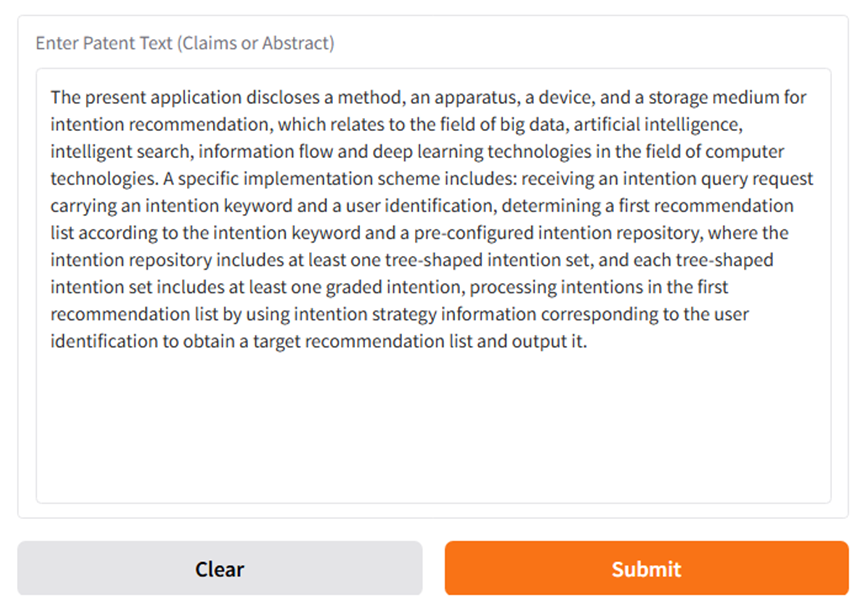
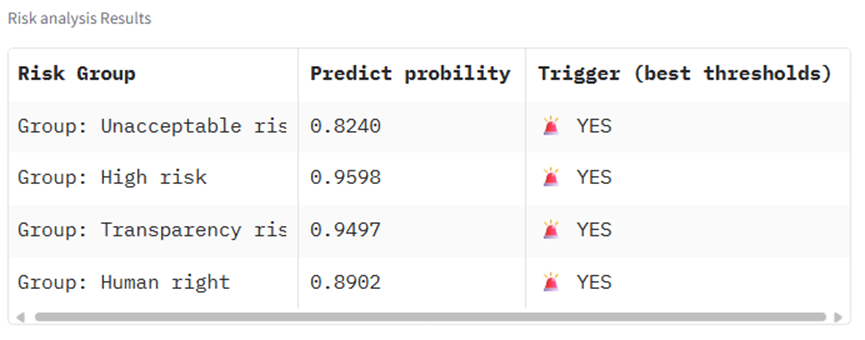
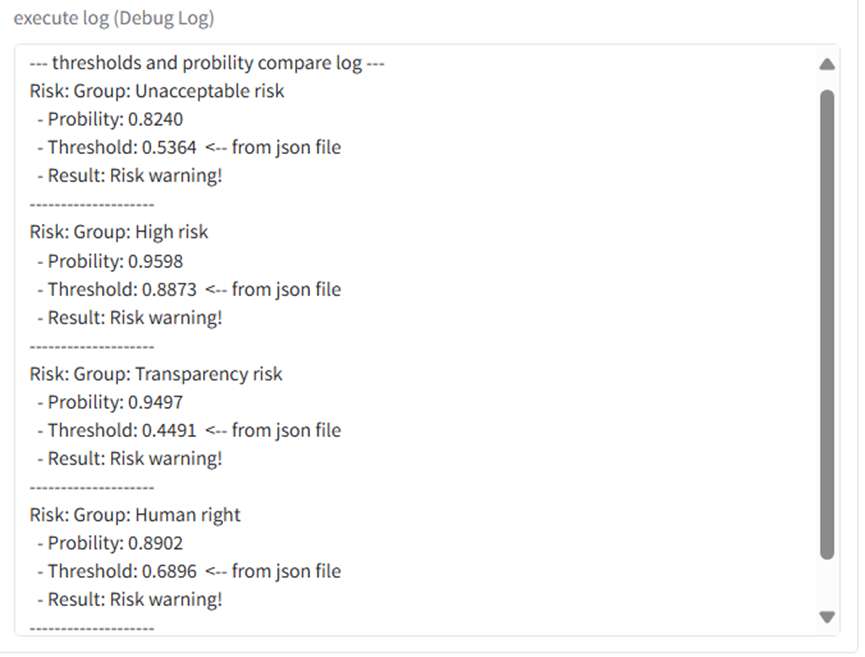

In [ ]:
@article{abid2019gradio,
  title = {Gradio: Hassle-Free Sharing and Testing of ML Models in the Wild},
  author = {Abid, Abubakar and Abdalla, Ali and Abid, Ali and Khan, Dawood and Alfozan, Abdulrahman and Zou, James},
  journal = {arXiv preprint arXiv:1906.02569},
  year = {2019},
}

## Supervised Fine-Tuning (Automated Tuning) - Legal-BERT

In [ ]:
@inproceedings{akiba2019optuna,
  title={{O}ptuna: A Next-Generation Hyperparameter Optimization Framework},
  author={Akiba, Takuya and Sano, Shotaro and Yanase, Toshihiko and Ohta, Takeru and Koyama, Masanori},
  booktitle={The 25th ACM SIGKDD International Conference on Knowledge Discovery \& Data Mining},
  pages={2623--2631},
  year={2019}
}

In [ ]:
# new model, new import libraries
# !pip install -q optuna # install
import pandas as pd
import numpy as np
import torch
import re
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, precision_recall_curve
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EvalPrediction

In [ ]:
# Data preparation
print("--- --- combine (4 risk groups) --- ---")

# 33 risk columns into 4 categories
group_prefixes = [
    'Unacceptable risk',
    'High risk',
    'Transparency risk',
    'Human right'
]
# create new datframe
# keep processed_text and risk cols
df_model_data = df_final[['processed_text']].copy()
grouped_risk_columns = []
for prefix in group_prefixes:
    group_name = f"Group: {prefix}"
    grouped_risk_columns.append(group_name)
    original_columns = [col for col in df_final.columns if col.startswith(prefix)]
    if original_columns:
        df_model_data[group_name] = df_final[original_columns].max(axis=1)
    else:
        df_model_data[group_name] = 0
# cleaning data
df_model_data.dropna(subset=['processed_text'], inplace=True)
df_model_data = df_model_data[df_model_data['processed_text'].str.strip() != ''].reset_index(drop=True)
print("\nAfter combine，each risk group Number Of Sample(support):")
print(df_model_data[grouped_risk_columns].sum())
print(f"Data prepare complete!")

# almost same code as supervised fine-tuning(manual)
print("\n--- Start model training ---")

model_checkpoint = "nlpaueb/legal-bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
train_df, val_df = train_test_split(df_model_data, test_size=0.2, random_state=42)
# formatting and Tokenization
train_df['labels'] = train_df[grouped_risk_columns].values.tolist()
val_df['labels'] = val_df[grouped_risk_columns].values.tolist()
train_df_for_dataset = train_df.drop(columns=grouped_risk_columns)
val_df_for_dataset = val_df.drop(columns=grouped_risk_columns)
train_dataset = Dataset.from_pandas(train_df_for_dataset)
val_dataset = Dataset.from_pandas(val_df_for_dataset)
def tokenize_function(examples):
    return tokenizer(examples["processed_text"], padding="max_length", truncation=True, max_length=512)
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)
columns_to_keep = ['labels', 'input_ids', 'attention_mask', 'token_type_ids']
columns_to_remove = [col for col in tokenized_train_dataset.column_names if col not in columns_to_keep]
tokenized_train_dataset = tokenized_train_dataset.remove_columns(columns_to_remove)
tokenized_val_dataset = tokenized_val_dataset.remove_columns(columns_to_remove)
tokenized_train_dataset.set_format("torch")
tokenized_val_dataset.set_format("torch")
# weight
train_labels_np = np.array(train_df[grouped_risk_columns].values)
pos_counts = np.sum(train_labels_np, axis=0)
neg_counts = len(train_labels_np) - pos_counts
pos_weight = np.where(pos_counts > 0, neg_counts / pos_counts, 1.0)
pos_weight_tensor = torch.tensor(pos_weight, dtype=torch.float)
print("Finish- weight caculate")

# search best set
print("\n--- Auto best arg search ---")

# Define the model initialization function
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(
        model_checkpoint,
        num_labels=len(grouped_risk_columns),
        problem_type="multi_label_classification"
    )

# define a custom weighted-loss Trainer
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor.to(model.device))
        loss = loss_fct(logits, labels.float())
        return (loss, outputs) if return_outputs else loss

# predefine a set of training arguments (some will be overridden by Optuna during hyperparameter search)
training_args = TrainingArguments(
    output_dir="./hyperparam-search-results",
    report_to="none",
    num_train_epochs=3, # Use fewer epochs to speed up
    per_device_train_batch_size=8, # a default batch size
    learning_rate=2e-5, # a default learning rate
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    disable_tqdm=True # Disable progress bar
)

# set training parameters
def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    true_labels = p.label_ids
    y_pred = (torch.sigmoid(torch.from_numpy(preds)).numpy() >= 0.5).astype(int)
    f1 = f1_score(y_true=true_labels, y_pred=y_pred, average='weighted', zero_division=0)
    return {"f1_weighted": f1}

# instantiate a Trainer for hyperparameter search
trainer = WeightedLossTrainer(
    model_init=model_init,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# hyperparameter search space
def optuna_hp_space(trial: optuna.Trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [4, 8]),
    }

# execute automated hyperparameter tuning
best_trial = trainer.hyperparameter_search(
    direction="maximize",
    backend="optuna",
    hp_space=optuna_hp_space,
    n_trials=10, # Try 10 different parameter sets
)

print("\n--- Search Complete！---")
print("best parameter set:", best_trial.hyperparameters)
print("and its F1 score:", best_trial.objective)


# Training and Evaluation
print("\n--- Final Training(use best set) ---")

# Update TrainingArguments with the best hyperparameters found
for k, v in best_trial.hyperparameters.items():
    setattr(training_args, k, v)
# for the final formal training
training_args.num_train_epochs = 8
training_args.evaluation_strategy = "epoch"
training_args.save_strategy = "epoch"
training_args.load_best_model_at_end = True # early stopping and load the best model
training_args.metric_for_best_model = "f1_weighted"
training_args.greater_is_better = True
training_args.disable_tqdm = False # Re-enable progress bar

# Trainer with the best hyperparameters
trainer = WeightedLossTrainer(
    model=model_init(), # init model
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# final training
trainer.train()

print("--- Training Finish ---")


# Evaluation
print("\n--- Start optimized and compare ---")
# model prediction results
preds_output = trainer.predict(tokenized_val_dataset)
probabilities = torch.sigmoid(torch.from_numpy(preds_output.predictions)).numpy()
y_true = preds_output.label_ids

# a comparison report using 0.5 as the default threshold
print("\n" + "="*60)
print("--- Report 1: use【(general) 0.5 thresholds】eval report ---")
print("="*60)
baseline_report = classification_report(y_true, (probabilities >= 0.5).astype(int), target_names=grouped_risk_columns, zero_division=0)
print(baseline_report)


# the optimal threshold for each major risk category
best_thresholds_per_class = {}
for i, risk_name in enumerate(grouped_risk_columns):
    precision, recall, thresholds = precision_recall_curve(y_true[:, i], probabilities[:, i])
    f1s = (2 * precision * recall) / (precision + recall + 1e-7)
    f1s = f1s[:-1]
    thresholds = thresholds[:len(f1s)]
    if len(f1s) > 0:
        best_f1_idx = np.argmax(f1s)
        best_thresholds_per_class[risk_name] = thresholds[best_f1_idx]
    else:
        best_thresholds_per_class[risk_name] = 0.5

# the final report
print("\n" + "="*60)
print("--- Report 2: use【best threshold(each group)】eval report (final result) ---")
print("="*60)
y_pred_optimized = np.zeros_like(probabilities)
for i, risk_name in enumerate(grouped_risk_columns):
    threshold = best_thresholds_per_class[risk_name]
    y_pred_optimized[:, i] = (probabilities[:, i] >= threshold).astype(int)

optimized_report = classification_report(y_true, y_pred_optimized, target_names=grouped_risk_columns, zero_division=0)
print(optimized_report)

If the result image does not display correctly
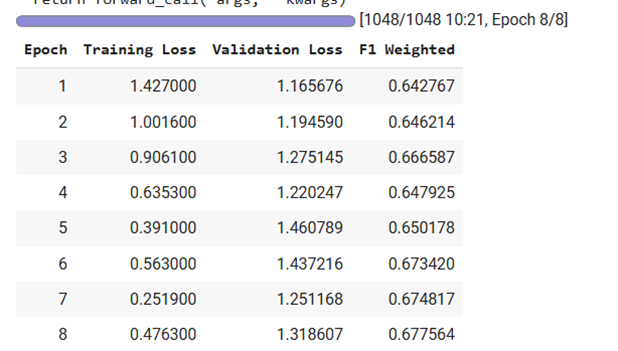
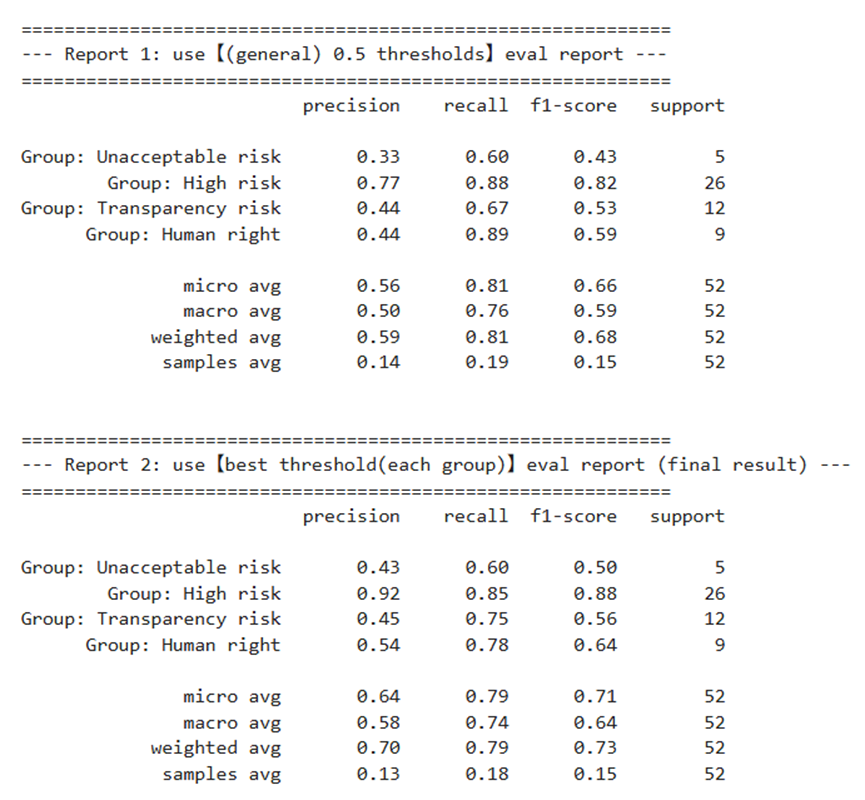

In [ ]:
# # Save the model and the optimal threshold
# save model Tokenizer
model_save_directory = "./my_final_risk_classifier"
trainer.save_model(model_save_directory)
tokenizer.save_pretrained(model_save_directory)
print(f"模型和 Tokenizer 已成功保存至: {model_save_directory}")

# save best_thresholds_per_class
thresholds_to_save = {key: float(value) for key, value in best_thresholds_per_class.items()}
thresholds_save_path = f"{model_save_directory}/best_thresholds.json"
with open(thresholds_save_path, 'w') as f:
    json.dump(thresholds_to_save, f, indent=4)
print(f"最佳門檻值已成功保存至: {thresholds_save_path}")

模型和 Tokenizer 已成功保存至: ./my_final_risk_classifier
最佳門檻值已成功保存至: ./my_final_risk_classifier/best_thresholds.json


In [ ]:
# df_model_data.to_csv("model_data.csv")

In [ ]:
# nstall and Import Necessary Libraries

import gradio as gr
import torch
import json
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load Your Core Assets
print("--- Loading trained model assets... ---")
model_path = "./my_final_risk_classifier"
thresholds_path = "./my_final_risk_classifier/best_thresholds.json"
try:
    loaded_model = AutoModelForSequenceClassification.from_pretrained(model_path)
    loaded_tokenizer = AutoTokenizer.from_pretrained(model_path)
    with open(thresholds_path, 'r') as f:
        loaded_thresholds = json.load(f)
    risk_categories = list(loaded_thresholds.keys())
    print("Model, Tokenizer, and optimal thresholds loaded successfully!")
except FileNotFoundError:
    print("Error: Model or threshold file not found.")
    exit()

# Set the model to evaluation mode
loaded_model.eval()

# Define the Core Prediction Function (returns DataFrame and debug log)
def predict_risks(text_input):
    """
    Receives a piece of text, outputs a results DataFrame and a debug log string
    containing the detailed comparison process.
    """
    if not text_input or not text_input.strip():
        # Return an empty DataFrame and a prompt message
        return pd.DataFrame(columns=["Risk Category", "Predicted Probability", "Triggered (by Optimal Threshold)"]), "Please enter text to be analyzed."

    # 1. Tokenize the input text
    inputs = loaded_tokenizer(text_input, padding=True, truncation=True, max_length=512, return_tensors="pt")

    # 2. Perform model prediction
    with torch.no_grad():
        outputs = loaded_model(**inputs)

    # 3. Convert the model's raw outputs (logits) to probabilities between 0 and 1
    probabilities = torch.sigmoid(outputs.logits).numpy()[0]

    # Create a list to collect debug messages instead of printing directly
    debug_log_lines = ["--- Backend Prediction & Threshold Comparison Log ---"]

    results = []
    # Iterate through each risk category
    for i, risk_name in enumerate(risk_categories):
        prob = probabilities[i]

        # Retrieve the corresponding optimal threshold from the loaded dictionary
        optimal_threshold = loaded_thresholds.get(risk_name, 0.5)

        # Add debug messages to the list
        debug_log_lines.append(f"Analyzing Category: {risk_name}")
        debug_log_lines.append(f"  - Predicted Probability: {prob:.4f}")
        debug_log_lines.append(f"  - Threshold Used: {optimal_threshold:.4f}  <-- Loaded from JSON file")

        triggered = "🚨 YES" if prob >= optimal_threshold else "✅ NO"

        if triggered == "🚨 YES":
            debug_log_lines.append("  - Result: Risk Triggered!")

        debug_log_lines.append("-" * 20)

        results.append({
            "Risk Category": risk_name,
            "Predicted Probability": f"{prob:.4f}",
            "Triggered (by Optimal Threshold)": triggered
        })

    debug_log_lines.append("--- Comparison Complete ---")

    # Combine all collected debug messages into a single string with newlines
    debug_log_string = "\n".join(debug_log_lines)

    results_df = pd.DataFrame(results)

    # Return two results: the DataFrame and the debug log string
    return results_df, debug_log_string

#  Create and Launch the Gradio Interactive Interface (receiving two outputs)
print("\n--- Creating Gradio interactive interface... ---")

iface = gr.Interface(
    fn=predict_risks,  # Specify the core processing function
    inputs=gr.Textbox(
        lines=15,
        label="Enter Patent Text (Claims or Abstract)",
        placeholder="Please paste the patent text you wish to analyze here..."
    ),
    # The outputs parameter is now a list to correspond to the two return values of the function
    outputs=[
        gr.DataFrame(
            headers=["Risk Category", "Predicted Probability", "Triggered (by Optimal Threshold)"],
            label="Risk Analysis Results"
        ),
        gr.Textbox(
            label="Backend Execution Log (Debug Log)",
            lines=15
        )
    ],
    title="Automated AI Risk Analysis Tool for Patents",
    description="This tool uses a fine-tuned Legal-BERT model to analyze input patent text. It determines whether the text contains various categories of AI risk based on pre-trained optimal thresholds.",
    allow_flagging="never"
)

# Launch the interface
# debug=True provides more detailed error messages if something goes wrong
# share=True generates a public, shareable link (valid for 72 hours)
iface.launch(debug=True, share=True)

If the result image does not display correctly
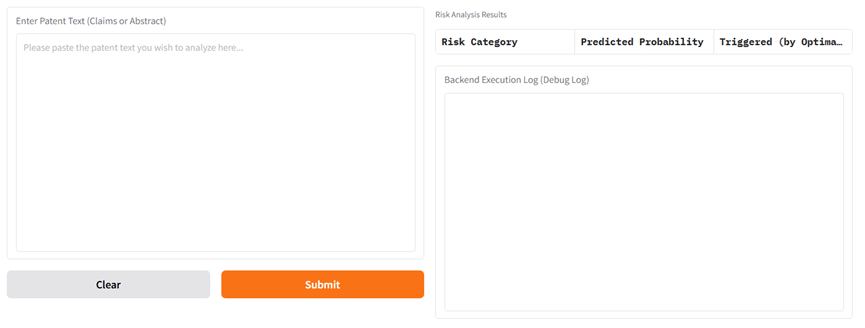
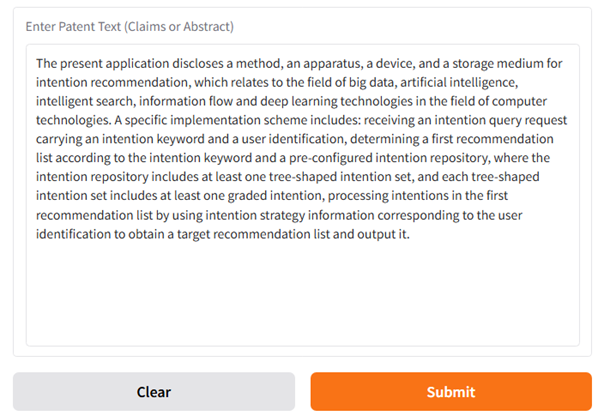
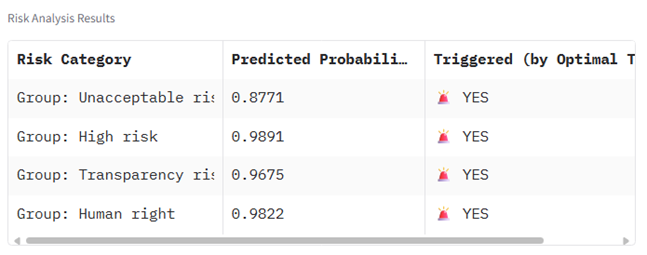
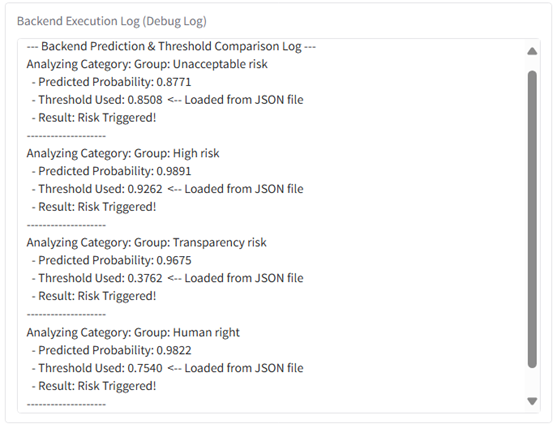

## Classical ML (TF-IDF Baseline)

In [ ]:
# import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier 
from sklearn.metrics import classification_report, f1_score

In [ ]:
# Data Preparation
# need a DataFrame named df_model_data

print("--- Traditional machine learning ---")

# read df_model_data file
# df_model_data = pd.read_csv('model_data.csv') 

# retrieve the names of the label columns
grouped_risk_columns = [col for col in df_model_data.columns if col.startswith('Group:')]

# features (X) and targets (y)
X = df_model_data['processed_text']
y = df_model_data[grouped_risk_columns]

# Split the data into training and validation sets using the same random_state for reproducibility
# train 80, test 20
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print(f"Data splitting completed -> Training set size: {len(X_train)}, Validation set size: {len(X_val)}")


# Text Feature Engineering (TF-IDF)
print("\n--- Text vectorization using TF-IDF ---")

# initialize TfidfVectorizer
# max_features=5000: 
# ngram_range=(1, 2): Include both unigrams and bigrams
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# learn the vocabulary and transform the training set into TF-IDF vectors
# .fit_transform() on traiining data
X_train_tfidf = vectorizer.fit_transform(X_train)

# Transform the validation set using the learned vocabulary
# .transform() on val data
X_val_tfidf = vectorizer.transform(X_val)

print("Text vectorization completed")
print(f"TF-IDF matrix shape (training set): {X_train_tfidf.shape}")


# Training model
print("\n--- Training logistic regression classifier ---")

# Initialize a basic logistic regression classifier
# C=1.0: default value
# solver='liblinear':  for small to medium-sized datasets
# add class_weight='balanced' automatically handle class imbalance
base_classifier = LogisticRegression(
    C=1.0,
    solver='liblinear',
    random_state=42,
    class_weight='balanced'
)


# use OneVsRestClassifier handle multi-label classification
# trains a separate binary classifier for each risk category
model = OneVsRestClassifier(base_classifier)

# Train the model using TF-IDF vectors
model.fit(X_train_tfidf, y_train)

print("Model training complete")


#  Evaluation 
print("\n--- Evaluating model performance on validation set ---")

# predictions on the validation set
y_pred = model.predict(X_val_tfidf)

# Output a detailed classification report
print("\n--- TF-IDF + Logistic Regression model report ---")
report = classification_report(y_val, y_pred, target_names=grouped_risk_columns, zero_division=0)
print(report)



--- Traditional machine learning ---
Data splitting completed -> Training set size: 523, Validation set size: 131

--- Text vectorization using TF-IDF ---
Text vectorization completed
TF-IDF matrix shape (training set): (523, 5000)

--- Training logistic regression classifier ---
Model training complete

--- Evaluating model performance on validation set ---

--- TF-IDF + Logistic Regression model report ---
                          precision    recall  f1-score   support

Group: Unacceptable risk       0.29      0.80      0.42         5
        Group: High risk       0.65      0.65      0.65        26
Group: Transparency risk       0.37      0.58      0.45        12
      Group: Human right       0.75      0.33      0.46         9

               micro avg       0.49      0.60      0.54        52
               macro avg       0.51      0.59      0.50        52
            weighted avg       0.57      0.60      0.55        52
             samples avg       0.15      0.14      0.13   

If the result image does not show correctly

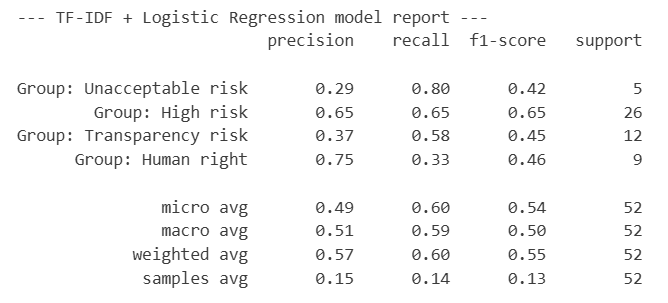

## Semantic Similarity (Enhanced)

In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt

df_model_data = pd.read_csv("/content/model_data.csv")

In [ ]:
print("--- Data preparation ---")

grouped_risk_columns = [col for col in df_model_data.columns if col.startswith('Group:')]

# the same sixe 80/20 and random_state =42
dev_df, test_df = train_test_split(
    df_model_data,
    test_size=0.2,
    random_state=42
)

print(f"Dataset split completed! -> dev_df size: {len(dev_df)}, test_df size: {len(test_df)}")

print("\n--- enriched risk definitions ---")

# risk definition
enriched_group_definitions = {
    'Group: Unacceptable risk': "AI systems whose use is considered a clear threat to the safety, livelihoods, and rights of people. This includes systems for social scoring, exploitation of vulnerabilities, or real-time remote biometric identification in public spaces for law enforcement.",
    'Group: High risk': "AI systems that can negatively affect safety or fundamental rights, particularly when used in critical infrastructures like transport, education, employment, or the administration of justice. These systems require rigorous assessment throughout their lifecycle.",
    'Group: Transparency risk': "AI systems, such as deep fakes or chatbots, that generate or manipulate content where there is a risk that a person may not be aware they are interacting with an artificial system. This necessitates clear disclosure to maintain trust and informed consent.",
    'Group: Human right': "AI systems that could negatively impact fundamental human rights, including but not limited to the right to dignity, freedom from discrimination, privacy, and a fair trial, as defined in international human rights law."
}

risk_definitions_list_enriched = [enriched_group_definitions[col] for col in grouped_risk_columns]

print("combine (4 groups)")

print("\n--- Loading Sentence-Transformer model and Vector generation ---")

model = SentenceTransformer('all-mpnet-base-v2')

risk_embeddings = model.encode(risk_definitions_list_enriched, convert_to_tensor=True, show_progress_bar=True)
dev_claim_embeddings = model.encode(dev_df['processed_text'].tolist(), convert_to_tensor=True, show_progress_bar=True)

print("\n--- Find best thresholds ---")

cosine_scores = util.cos_sim(dev_claim_embeddings, risk_embeddings)
cosine_scores_np = cosine_scores.cpu().numpy()

true_labels = dev_df[grouped_risk_columns].values

thresholds = np.arange(0.3, 0.8, 0.01) # try from 0.3 to 0.8 0.01 each
f1_scores = []

for threshold in thresholds:
    predicted_labels = (cosine_scores_np >= threshold).astype(int)
    f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=0)
    f1_scores.append(f1)

if f1_scores:
    best_f1_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_f1_index]
    best_f1_score = f1_scores[best_f1_index]
    print(f"Best F1 score: {best_f1_score:.4f}")
    print(f"Best threshold: {best_threshold:.2f}")

    # Best F1 score: 0.1337
# Best threshold: 0.30

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, f1_scores, marker='.', linestyle='-')
    plt.axvline(x=best_threshold, color='r', linestyle=':', label=f'Best threshold = {best_threshold:.2f}')
    plt.title('F1 score vs. Similarity Threshold on 4 Groupe')
    plt.xlabel('Similarity Threshold')
    plt.ylabel('weighted F1 Score')
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    best_threshold = 0.5 # defult value prevent empty value
    print("error，use threshold = 0.5")

print(f"\n--- use【best threshold: ({best_threshold:.2f})】eval report ---")

test_claim_embeddings = model.encode(test_df['processed_text'].tolist(), convert_to_tensor=True, show_progress_bar=True)

test_cosine_scores = util.cos_sim(test_claim_embeddings, risk_embeddings)
test_cosine_scores_np = test_cosine_scores.cpu().numpy()

test_true_labels = test_df[grouped_risk_columns].values

final_predicted_labels = (test_cosine_scores_np >= best_threshold).astype(int)

print("\n--- Final report ---")
report = classification_report(test_true_labels, final_predicted_labels, target_names=grouped_risk_columns, zero_division=0)
print(report)

## confusion matrix

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
# Import all necessary libraries
import torch
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer
import matplotlib.pyplot as plt
import seaborn as sns

# Load all pre-trained assets from file
print("--- Load all pre-trained assets from file ---")

model_path = "./legal-bert-optimized-v1"
thresholds_path = f"{model_path}/best_thresholds.json"

try:
    # Load model and tokenizer directly from the saved path
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path)

    # Load the best thresholds
    with open(thresholds_path, 'r') as f:
        best_thresholds_per_class = json.load(f)

    grouped_risk_columns = list(best_thresholds_per_class.keys())
    print("loaded successfully！")

except FileNotFoundError:
    print(f"Error: '{model_path}' make sure is correct and the files are uploaded/extracted.")
    exit()

# Move model to GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()
print(f"Model is ready and running on {device} ")

# Prepare the validation set for evaluation
print("\n--- Preparing the validation set for evaluation ---")

# read df_model_data.csv
try:
    df_model_data = pd.read_csv('model_data.csv')
except FileNotFoundError:
    print("Error")
    exit()

# Re-split the validation set using the exact same parameters as during training
_, val_df = train_test_split(df_model_data, test_size=0.2, random_state=42)

val_labels_int = val_df[grouped_risk_columns].values
val_df['labels'] = np.array(val_labels_int, dtype=np.float32).tolist()
val_df_for_dataset = val_df.drop(columns=grouped_risk_columns)

# Convert validation set to Dataset object and apply tokenization
val_dataset = Dataset.from_pandas(val_df_for_dataset)
def tokenize_function(examples):
    return tokenizer(examples["processed_text"], padding="max_length", truncation=True, max_length=512)
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)
columns_to_keep = ['labels', 'input_ids', 'attention_mask', 'token_type_ids']
columns_to_remove = [col for col in tokenized_val_dataset.column_names if col not in columns_to_keep]
tokenized_val_dataset = tokenized_val_dataset.remove_columns(columns_to_remove)
tokenized_val_dataset.set_format("torch")
print("Validation set is ready")

# generate confusion matrices
print("\n--- Running prediction and generating confusion matrices ---")

# a temporary Trainer to perform predictio
temp_trainer = Trainer(model=model)
preds_output = temp_trainer.predict(tokenized_val_dataset)
probabilities = torch.sigmoid(torch.from_numpy(preds_output.predictions)).numpy()
y_true = preds_output.label_ids

# Generate final binary predictions (0/1) using the loaded best thresholds
y_pred = np.zeros_like(probabilities)
for i, risk_name in enumerate(grouped_risk_columns):
    threshold = best_thresholds_per_class[risk_name]
    y_pred[:, i] = (probabilities[:, i] >= threshold).astype(int)

# Compute multilabel confusion matrices
mcm = multilabel_confusion_matrix(y_true, y_pred)

# Visualize confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()

for i, risk_name in enumerate(grouped_risk_columns):
    disp = ConfusionMatrixDisplay(confusion_matrix=mcm[i], display_labels=['No Risk', 'Risk'])
    disp.plot(ax=axes[i], cmap='Blues')
    axes[i].set_title(f'Confusion Matrix for:\n{risk_name}')

plt.tight_layout()
plt.show()